# Lab 3 — dimensionality reduction

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np

from operator import itemgetter

%matplotlib inline
plt.style.use("ggplot")

In [2]:
!hdfs dfs -cat /ix/ml-20m/genome-tags.txt | tail -n 2

{"tagId": 1127, "tag": "zombie"}
{"tagId": 1128, "tag": "zombies"}


In [3]:
data = sc.textFile("/ix/ml-20m/genome-tags.txt").map(json.loads)
tag2name = dict(data.map(itemgetter("tagId", "tag")).collect())

# Exercice 3.1

In [4]:
data = sc.textFile("/ix/ml-20m/genome-scores.txt").map(json.loads)

In [5]:
movies = data.map(itemgetter("movieId")).distinct()
nbMovies = movies.count()
#map to remember which movies is in which row in the matrix
movies_index = dict(movies.zipWithIndex().collect())
tags = data.map(itemgetter("tagId")).distinct()
nbTags = tags.count()

In [6]:
#map of the form [(movieId,tagId),relevance]
score_map = data.map(itemgetter("movieId", "tagId", "relevance")).map(lambda x : ((x[0],x[1]),x[2]))

In [7]:
scores = score_map.collect()

In [8]:
#filling the matrix with datas
matrix = np.ndarray(shape=(nbMovies,nbTags))
for score in scores:
    movieID = score[0][0]
    tagID = score[0][1]
    matrix[(movies_index[movieID],tagID -1 )] = score[1]

In [9]:
#computing variances for all columns
var_array = np.var(matrix,axis = 0)
total_variance = sum(var_array)
sorted_var_array = np.sort(var_array)

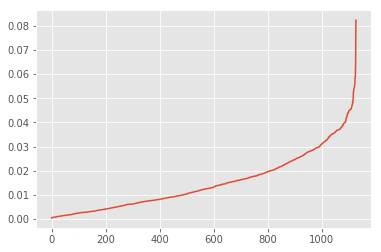

In [13]:
plt.plot(sorted_var_array, label='Test')
plt.show()

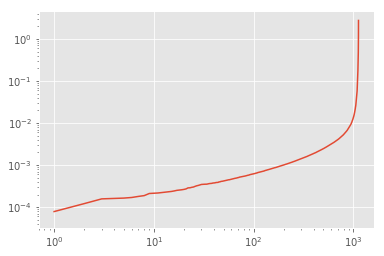

In [14]:
centered_matrix = matrix - np.mean(matrix,axis = 0)
covariance_matrix = np.cov(centered_matrix, rowvar=False, bias = True)
values,vectors = np.linalg.eigh(covariance_matrix)
plt.plot(values)
plt.yscale('log')
plt.xscale('log')
plt.show()

In [12]:
variance_PCS = 0;
index = len(vectors)
while index > 0 and variance_PCS < 2 / 3:
    index -= 1
    PC = np.matmul(centered_matrix,vectors[:,index])
    partial_var = np.var(PC) / total_variance
    variance_PCS += partial_var
    print("Principal component " + str(len(vectors) - index) + " captures " + str(partial_var * 100) +"% of the total variance")
    
print(str(len(vectors)-index) + " components capture " + str(variance_PCS * 100) + "% of the total variance")

Principal component 1 captures 16.0998401824% of the total variance
Principal component 2 captures 7.14231474524% of the total variance
Principal component 3 captures 5.82421785317% of the total variance
Principal component 4 captures 3.87194266108% of the total variance
Principal component 5 captures 3.42494118574% of the total variance
Principal component 6 captures 2.7735405351% of the total variance
Principal component 7 captures 2.69809092675% of the total variance
Principal component 8 captures 2.3226015567% of the total variance
Principal component 9 captures 1.99696401373% of the total variance
Principal component 10 captures 1.68924810457% of the total variance
Principal component 11 captures 1.52504419883% of the total variance
Principal component 12 captures 1.36710573857% of the total variance
Principal component 13 captures 1.30008923777% of the total variance
Principal component 14 captures 1.21490078948% of the total variance
Principal component 15 captures 1.12693104698

As seen above, 37 components capture 66.98% of the total variance

In [74]:
def print_max_min_PC(PC):
    PC_index = sorted([(x,index[0]) for index, x in np.ndenumerate(PC)])
    #remember : tagId n is at index n-1
    tag_minimum = [pair[1] + 1 for pair in PC_index[:10]]
    tag_maximum = [pair[1] + 1 for pair in PC_index[-10:]][::-1]
    print("Maximum: ")
    for tag in tag_maximum:
        print(tag2name[tag])

    print()    
    print("Minimum")
    for tag in tag_minimum:
        print(tag2name[tag])
    return tag_minimum, tag_maximum

### First principal component

In [75]:
PC1 = vectors[:,-1]
mini_PC1, maxi_PC1 = print_max_min_PC(PC1)

Maximum: 
talky
social commentary
criterion
imdb top 250
great acting
drama
oscar (best directing)
bleak
dramatic
cinematography

Minimum
predictable
so bad it's funny
bad plot
silly
silly fun
horrible
franchise
lame
big budget
comedy


### Second principal component

In [76]:
PC2 = vectors[:,-2]
mini_PC2, maxi_PC2 = print_max_min_PC(PC2)

Maximum: 
intimate
relationships
criterion
melancholic
loneliness
golden palm
meditative
art house
melancholy
sexual

Minimum
action
special effects
big budget
chase
fast paced
suspense
good action
plot
pg-13
action packed


### Third principal component

In [78]:
PC3 = vectors[:,-3]
mini_PC3, maxi_PC3 = print_max_min_PC(PC3)

Maximum: 
feel-good
sentimental
love story
heartwarming
touching
romantic
sweet
courage
girlie movie
feel good movie

Minimum
horror
weird
creepy
splatter
stylish
cult classic
disturbing
violence
cult film
dark


### Fourth principal component

In [79]:
PC4 = vectors[:,-4]
mini_PC4, maxi_PC4 = print_max_min_PC(PC4)

Maximum: 
visual
visually stunning
imagination
sci-fi
scifi
visually appealing
science fiction
sci fi
special effects
beautifully filmed

Minimum
corruption
crime
murder
police investigation
thriller
suspense
violence
police corruption
gangsters
manipulation


### Fifth principal component

In [80]:
PC5 = vectors[:,-5]
mini_PC5, maxi_PC5 = print_max_min_PC(PC5)

Maximum: 
thriller
conspiracy
secrets
suspenseful
tense
mystery
suspense
investigation
murder mystery
betrayal

Minimum
comedy
funny
hilarious
goofy
humorous
humor
very funny
cult classic
quotable
funny as hell
